In [1]:
################################################################################
# Title: top level file for ASL net
#
# Author: Mansur Amin
#
# Description: Top leve file for ASL NN.
#
# Current Status: Calls all functions and imports all files needed to run
# training net.
################################################################################

# libraries
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import ASL_Class as asl
import torch
import torch.autograd as ag

('Normalize_MNIST_images', (27456, 784))
('Normalize_MNIST_images', (7173, 784))


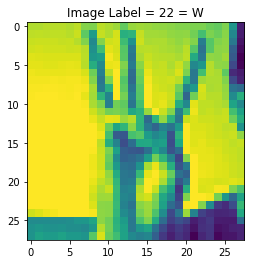

In [3]:
#####################################################################
# Main Program
#####################################################################

####### Read data

# Windows Path
# train_path = 'C:\\Users\\maamin\\Desktop\\ECE_285_ML_DL\\data\\sign_mnist_train.csv'
# test_path = 'C:\\Users\\maamin\\Desktop\\ECE_285_ML_DL\\data\\sign_mnist_test.csv'

# Mac path
# train_path = '/Users/mansuramin/Desktop/ECE_285_ML/data/sign_mnist_train.csv'
# test_path = '/Users/mansuramin/Desktop/ECE_285_ML/data/sign_mnist_test.csv'

# Linux Server Path
train_path = '/datasets/home/56/256/maamin/asl_data/sign_mnist_train.csv'
test_path = '/datasets/home/56/256/maamin/asl_data/sign_mnist_test.csv'

# Load data
xtrain,ltrain = asl.read_data(train_path)
xtest,ltest = asl.read_data(test_path)

# Normalize
xtrain = asl.normalize_MNIST_images(xtrain)
xtest = asl.normalize_MNIST_images(xtest)

# Visualize data
indx = 10240
asl.vis_data(xtrain[indx,:],ltrain[indx])

# Change Types and reshape
xtrain = np.moveaxis(xtrain,0,1)
ltrain = ltrain.astype(np.int64)
xtest = np.moveaxis(xtest,0,1)
ltest = ltest.astype(np.int64)

In [4]:
# Reshape data in the form of 
# Batch size × Number of input channels × Image width × Image height
xtrain2 = xtrain.reshape(28,28,1,xtrain.shape[1])
xtest2 = xtest.reshape(28,28,1,xtest.shape[1])
xtrain = np.moveaxis(xtrain2,[2,3],[1,0])
xtest = np.moveaxis(xtest2,[2,3],[1,0])

# Print new vectors eo make sure deminsions are correct
print("xtrain2 = ", xtrain2.shape)
print("xtrain = ", xtrain.shape)
print("xtest2 = ", xtest2.shape)
print("xtest = ", xtest.shape)

xtrain2 =  (28, 28, 1, 27456)
xtrain =  (27456, 1, 28, 28)
xtest2 =  (28, 28, 1, 7173)
xtest =  (7173, 1, 28, 28)


In [5]:
# Convert from numpy to torch tensor
xtrain = torch.from_numpy(xtrain)
ltrain = torch.from_numpy(ltrain)
xtest = torch.from_numpy(xtest)

# place data on GPU's 
if torch.cuda.is_available() :
    xtrain = xtrain.cuda()
    ltrain = ltrain.cuda()
    xtest  = xtest.cuda()

# wrap tensor in autograd variable that lets you keep track of gradient for backprop
xtrain = ag.Variable(xtrain,requires_grad = True)
ltrain = ag.Variable(ltrain,requires_grad = False)
xtest  = ag.Variable(xtest ,requires_grad = False)

In [6]:
## Initalizing LeNet network

import torch.nn as nn 
import torch.nn.functional as F

# this is our neural netowkrs class that inherits from nn.Module
class LeNet(nn.Module) : 
    # here we defin our network structure
    def __init__(self) :
        super(LeNet,self).__init__()
        if torch.cuda.is_available() :
            self.conv1 = nn.Conv2d(1,6,5).double().cuda()  # output 24x24 
            self.conv2 = nn.Conv2d(6,16,5).double().cuda()
            self.fc1   = nn.Linear(256,120).double().cuda()
            self.fc2   = nn.Linear(120,84).double().cuda()
            self.fc3   = nn.Linear(84,10).double().cuda()

    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x) :
        size = x.size()[1:]
        return np.prod(size)

net = LeNet()
print(net)
        

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
params = list(net.parameters())
for i in range(len(params)) : 
    print(i, params[i].size())
    # 0 = output of conv1
    # 2 = output of conv2
    # 4,6,8 = fully connected layers
    # 1,3,5,7,9 = output of maxpool

0 torch.Size([6, 1, 5, 5])
1 torch.Size([6])
2 torch.Size([16, 6, 5, 5])
3 torch.Size([16])
4 torch.Size([120, 256])
5 torch.Size([120])
6 torch.Size([84, 120])
7 torch.Size([84])
8 torch.Size([10, 84])
9 torch.Size([10])


In [8]:
if torch.cuda.is_available() :
    yinit = net(xtest)

In [9]:
# print(100 * np.mean(ltest == yinit.data.numpy().T.argmax(axis =0)))

print(100 * np.mean(ltest == yinit.cpu().data.numpy().T.argmax(axis =0)))
# probability of success for 10 digits after feed forward path ith no back propigation
# if you have two classes probability of success is 50 % or 1/2
# if you have ten classes probability of success is 10% or 1/10

6.064408197406943


In [10]:
# minibatch gradient descent ith cross entropy 
N = xtrain.size()[0]            # training set size 
B = 100                         # minibatch size
NB = N / B                      # number of minibatches
T = 10                          # number of epochs
gamma = .001                    # learning rate
rho = .9                        # momentup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=gamma,momentum=rho)

In [11]:
import time
start = time.time()

for epoch in range(T) :
    running_loss = 0.0
    idxminibathches = np.random.permutation(NB) # shuffling 
    
    for k in range (NB) :
        i = idxminibathches[k] # index of minibatch
        
        # extract i-th minibatch from xtrain and ltrain 
        idxsmp = np.arange(i*B,np.min((i*B+B,N)))          # indicies of samples for i-th minibatch
        
        inputs = xtrain[idxsmp]
        labels = ltrain[idxsmp]
        
        # initalize the gradients to zero
        optimizer.zero_grad()
        
        # forward propigation 
        outputs = net(inputs)

        # error evulation 
        loss = criterion(outputs,labels)

        # back propigation 
        loss.backward()

        # paramater update
        optimizer.step()
        
        B = 10
        # print averaged loss per minibatch every 100 minibatches
        running_loss += loss[0]
        if k %B  == B-1 :
            print('[%d, %5d] loss: %3f' % (epoch+1, k+1, running_loss/B))
            running_loss = 0.0
        
        B = 100
print ('Finished Training')

end = time.time()

print(end - start)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1523240155148/work/torch/lib/THCUNN/SoftMaxCommon.cuh:464

In [ ]:
# testing phase
if torch.cuda.is_available() :
    yinit = net(xtest)

In [ ]:
print(100 * np.mean(ltest == yinit.cpu().data.numpy().T.argmax(axis =0)))
# probability of success for 10 digits after feed forward path ith no back propigation
# if you have two classes probability of success is 50 % or 1/2
# if you have ten classes probability of success is 10% or 1/10